<b> Install Libraries</b>

In [ ]:
# install libraries
!pip install geopandas rasterio arrow pyproj boto3 radiant-mlhub imagecodecs -qqq
!pip install awscli --ignore-installed six -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 526.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 124.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

<b>Import Libraries</b>

In [ ]:
#import libraries
import os
import json
import fiona
import arrow
import math
import glob
import shutil
from pathlib import Path

import numpy as np
import pandas as pd
from shapely.geometry import shape, mapping, GeometryCollection, box
from shapely.ops import transform
import pyproj
from tqdm.notebook import tqdm

import shapely
import geopandas as gpd #Similar to pandas but also loads geometries into dataframes
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon #Used for manipulating geometries and performing spatial queries

import rasterio as rio #Reading and writing raster data
import rasterio.mask
from rasterio.transform import Affine
from rasterio.profiles import DefaultGTiffProfile
from rasterio.crs import CRS as rasterioCRS
from rasterio import features as rio_features
import tifffile as tiff
from PIL import Image

import cv2
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from radiant_mlhub import Dataset
from radiant_mlhub import Collection
import torchvision

import torch.nn as nn
import torch.optim as optim

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torchsummary import summary
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, f1_score, classification_report

import warnings
warnings.filterwarnings("ignore")

import warnings
import urllib3

#Disable warnings for the urllib3 module
warnings.filterwarnings("ignore", category=urllib3.exceptions.InsecureRequestWarning)

<b>Load Dataset from Google Drive</b>

In [ ]:
#Login to RadiantML
!mlhub configure

API Key: d3b500310d2767c6001112fb047c830d32ba0830ea92cf3913ec56e69156e47f
Wrote profile to /root/.mlhub/profiles


In [ ]:
ds = Dataset.fetch('rti_rwanda_crop_type')

for c in ds.collections:
    print(c.id)

rti_rwanda_crop_type_labels
rti_rwanda_crop_type_source
rti_rwanda_crop_type_raw


In [ ]:
ROOT_PATH = "/content/data"

In [ ]:
#Download the data
for i, c in enumerate(ds.collections):
    print(c.id)
    collection = Collection.fetch(c.id)
    if i < 2:
        collection.download(ROOT_PATH)

rti_rwanda_crop_type_labels


  0%|          | 0/0.8 [00:00<?, ?M/s]

rti_rwanda_crop_type_source


  0%|          | 0/104.5 [00:00<?, ?M/s]

rti_rwanda_crop_type_raw


In [ ]:
#Unzip dataset
shutil.unpack_archive(f"{ROOT_PATH}/rti_rwanda_crop_type_labels.tar.gz", f"{ROOT_PATH}")
#shutil.unpack_archive(f"{ROOT_PATH}/rti_rwanda_crop_type_raw.tar.gz", f"{ROOT_PATH}")
shutil.unpack_archive(f"{ROOT_PATH}/rti_rwanda_crop_type_source.tar.gz", f"{ROOT_PATH}")

In [ ]:
labels_path = f"{ROOT_PATH}/rti_rwanda_crop_type_labels"  # label files
sources_path = f"{ROOT_PATH}/rti_rwanda_crop_type_source"  # source image files

#get the path to all image source files
source_images = []
label_images = []

for root, dirs, files in os.walk(sources_path):
    for file in files:
        if file.endswith(".png"):
            source_images.append(os.path.join(root, file))

for root, dirs, files in os.walk(labels_path):
    for file in files:
        if file.endswith("labels.json"):
            label_images.append(os.path.join(root, file))

#Sort the lists to ensure correct matching
source_images.sort()
label_images.sort()

#Create a DataFrame
data = {
    "Source Image": source_images,
    "Label Image": label_images
}

df = pd.DataFrame(data)

#Loop through the Label Image column
for i, row in df.iterrows():
    with open(row["Label Image"]) as f:
        label_data = json.load(f)
    label_name = label_data["label"]
    df.at[i, "Label Data"] = label_name

#Display the dataset in a table
df.head()

,Source Image,Label Image,Label Data
0,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_labels/rti_...,banana
1,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_labels/rti_...,maize
2,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_labels/rti_...,legumes
3,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_labels/rti_...,legumes
4,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_labels/rti_...,structure


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2606 entries, 0 to 2605
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Source Image  2606 non-null   object
 1   Label Image   2606 non-null   object
 2   Label Data    2606 non-null   object
dtypes: object(3)
memory usage: 61.2+ KB


In [ ]:
def plot_images(column_name):
    #Select random rows from the DataFrame
    sample_df = df.sample(12, random_state = 42)
    #Create subplots
    fig, axes = plt.subplots(2, 6, figsize=(12, 4))
    #Iterate over the subplots 
    for i, ax in enumerate(axes.flat):
        image_file_path = sample_df.iloc[i][column_name]
        image = Image.open(image_file_path)
        #Get the label name from the DataFrame
        label_name = sample_df.iloc[i]["Label Data"]

        #Plot the image and put labels
        ax.imshow(image)
        ax.set_title(label_name)
        ax.axis("off")
        
    #Display the plot
    plt.tight_layout()
    plt.show()

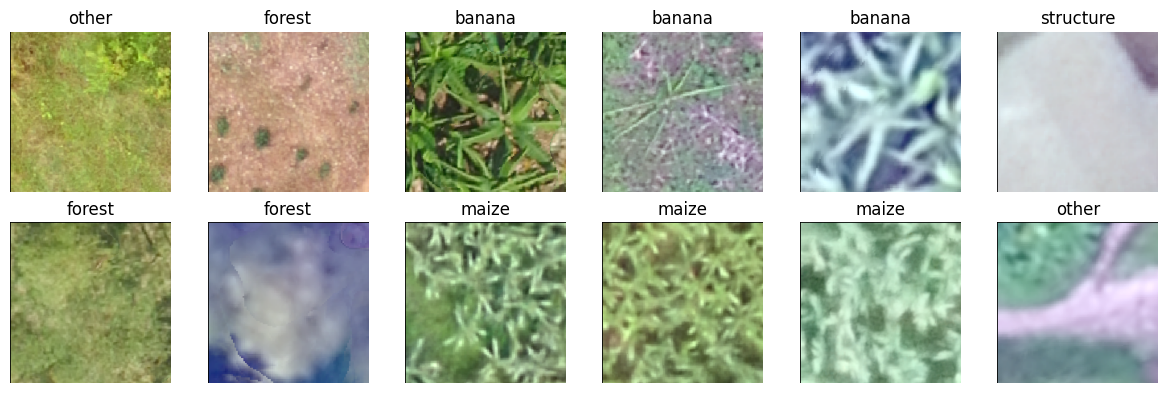

In [ ]:
#Call function
plot_images("Source Image")

<b>Using Non-local mean filtering to remove noise</b></br>
Non-local Means Filtering: This technique applies a weighted average of patches from throughout the image, based on their similarity to the patch being filtered. This can be effective at removing complex noise patterns, but can be computationally expensive.

In [ ]:
#Define the path to the source images
sources_path = f"{ROOT_PATH}/rti_rwanda_crop_type_source"

#Create a new directory to save the denoised images
denoised_path = f"{ROOT_PATH}/rti_rwanda_crop_type_denoised"
if not os.path.exists(denoised_path):
    os.makedirs(denoised_path)

Loop through the DataFrame
for i, row in df.iterrows():
    #Load the source image
    img_path = row["Source Image"]
    img = cv2.imread(img_path)

    #Apply non-local means filtering to remove noise
    denoised = cv2.fastNlMeansDenoisingColored(img, None, 5, 2, 3, 2)

    #Get the path to save the denoised image
    denoised_path = img_path.replace("image.png", "denoised.png")

    #Save the denoised image to the denoised directory
    cv2.imwrite(denoised_path, denoised)

    #Update the DataFrame with the path to the denoised image
    df.at[i, "Denoised Image"] = denoised_path

#Display the updated DataFrame with the path to the denoised images
df.head()

,Source Image,Label Image,Label Data,Denoised Image,Equalized Image,Stacked Image
0,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_labels/rti_...,banana,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...
1,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_labels/rti_...,maize,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...
2,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_labels/rti_...,legumes,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...
3,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_labels/rti_...,legumes,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...
4,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_labels/rti_...,structure,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...


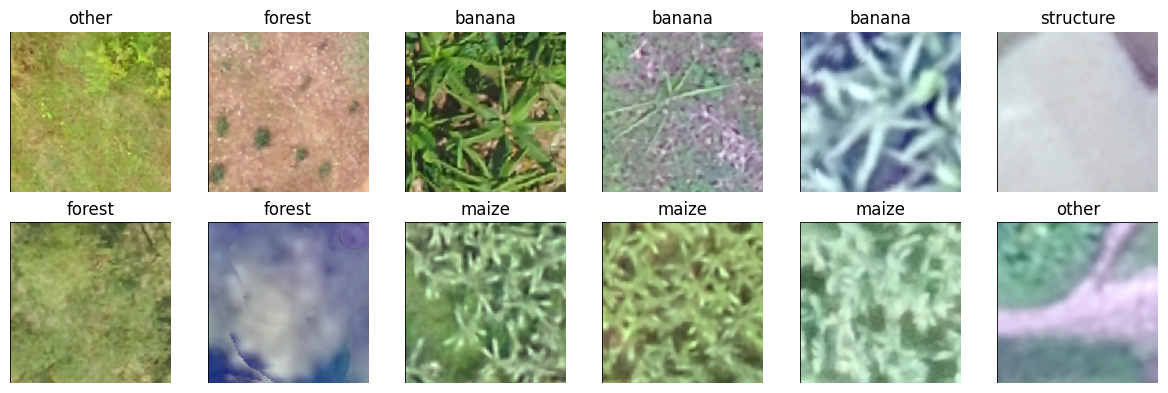

In [ ]:
#Call function
plot_images("Denoised Image")

<b> Contrast enhancement using adaptive equalization</b><br>
Adaptive equalization is a technique used in image processing to enhance the contrast of an image. It is a type of histogram equalization that adapts the transformation function to different regions of the image.

In [ ]:
#Define the path to the source images
sources_path = f"{ROOT_PATH}/rti_rwanda_crop_type_denoised"

#Loop through the DataFrame
for i, row in df.iterrows():
    #Load the source image
    img_path = row["Denoised Image"]
    img = cv2.imread(img_path)

    #Split the image into its RGB channels
    b, g, r = cv2.split(img)

    #Apply adaptive histogram equalization to each channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    b_eq = clahe.apply(b)
    g_eq = clahe.apply(g)
    r_eq = clahe.apply(r)

    #Merge the equalized RGB channels into a single image
    equalized = cv2.merge((b_eq, g_eq, r_eq))

    #Get the path to save the equalized image
    equalized_path = img_path.replace("denoised.png", "equalized.png")

    #Save the equalized image to the same directory as the source image
    cv2.imwrite(equalized_path, equalized)

    #Update the DataFrame with the path to the equalized image
    df.at[i, "Equalized Image"] = equalized_path

#Display the updated DataFrame with the path to the equalized images
df.head()

,Source Image,Label Image,Label Data,Denoised Image,Equalized Image,Stacked Image
0,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_labels/rti_...,banana,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...
1,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_labels/rti_...,maize,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...
2,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_labels/rti_...,legumes,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...
3,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_labels/rti_...,legumes,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...
4,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_labels/rti_...,structure,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...


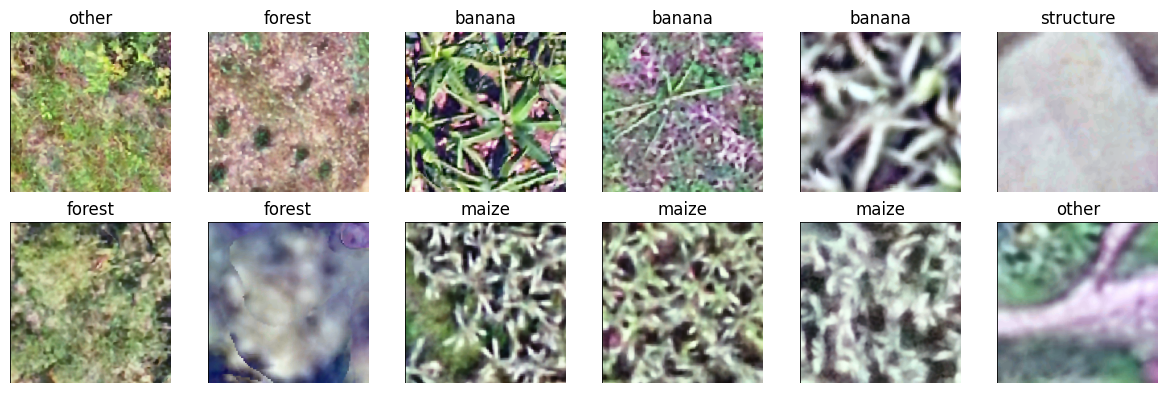

In [ ]:
#Call function
plot_images("Equalized Image")

<b>Apply the spectral indices in the equalized images: NDVI, GNDVI, NDWI</b><br>

In [ ]:
#Define the path to the source images
sources_path = f"{ROOT_PATH}/rti_rwanda_crop_type_equalized"

#Loop through the DataFrame
for i, row in df.iterrows():
    #Load the equalized image
    img_path = row["Equalized Image"]
    img = cv2.imread(img_path)

    #Convert the image to float32 data type
    img = img.astype(np.float32)

    #Calculate NDVI
    ndvi = (img[:, :, 2] - img[:, :, 1]) / (img[:, :, 2] + img[:, :, 1])
    #Calculate GNDVI
    gndvi = (img[:, :, 2] - img[:, :, 1]) / (img[:, :, 2] + img[:, :, 1] + 0.1)
    #Calculate NDWI
    ndwi = (img[:, :, 1] - img[:, :, 2]) / (img[:, :, 1] + img[:, :, 2])

    #Normalize the output to the range [0, 255]
    ndvi_norm = cv2.normalize(ndvi, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    gndvi_norm = cv2.normalize(gndvi, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    ndwi_norm = cv2.normalize(ndwi, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    #Stack the normalized outputs of each index
    stacked = np.dstack((ndvi_norm, gndvi_norm, ndwi_norm))

    #Get the path to save the stacked image
    stacked_path = img_path.replace("equalized.png", "stacked.png")

    #Save the stacked image to the same directory as the source image
    cv2.imwrite(stacked_path, stacked)

    #Update the DataFrame with the path to the stacked image
    df.at[i, "Stacked Image"] = stacked_path

#Display the updated DataFrame with the path to the stacked images
df.head()

,Source Image,Label Image,Label Data,Denoised Image,Equalized Image,Stacked Image
0,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_labels/rti_...,banana,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...
1,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_labels/rti_...,maize,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...
2,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_labels/rti_...,legumes,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...
3,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_labels/rti_...,legumes,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...
4,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_labels/rti_...,structure,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...,/content/data/rti_rwanda_crop_type_source/rti_...


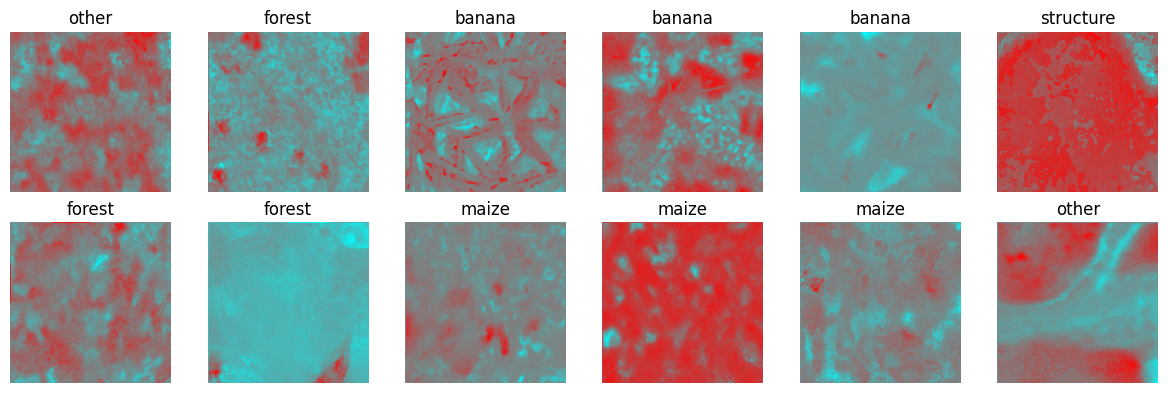

In [ ]:
#Call function
plot_images("Stacked Image")

In [ ]:
#Get type of crops
print(df['Label Data'].unique())

['banana' 'maize' 'legumes' 'structure' 'other' 'forest']


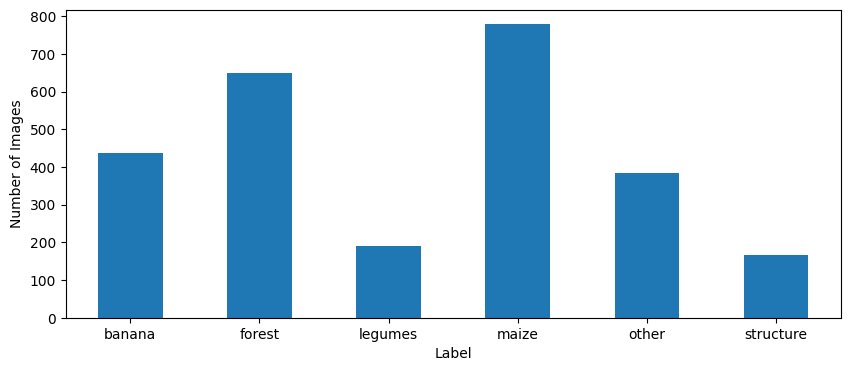

In [ ]:
#Group the images by labels
label_counts = df.groupby('Label Data').size()

#Plot the distribution
fig, ax = plt.subplots(figsize=(10, 4))
label_counts.plot.bar()
plt.xlabel('Label')
plt.ylabel('Number of Images')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

In [ ]:
config = {
    'batch_size': 128,
    'lr': 0.001,
    'epochs': 40, 
}

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        source_img_path = self.df.iloc[idx]["Source Image"]
        label_name = self.df.iloc[idx]["Label Data"]
        
        with Image.open(source_img_path) as img:
            if self.transform:
                img = self.transform(img)
                
        label_dict = {"Banana": 0, "Forest": 1, "Legumes": 2, "Maize": 3, "Other": 4, "Structure": 5}
        label = label_dict[label_name.capitalize()] 
        
        return img, label

In [ ]:
#Define transforms for image pre-processing/train
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
  ])

In [ ]:
#Define transforms for image pre-processing/test
test_transform = torchvision.transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
#Define the list of crop types
crop_types = ["banana", "forest", "legumes", "maize", "other", "structure"]
train_datasets, test_datasets = [], []

for crop_type in crop_types:
    #Determine the number of rows for training and testing
    crop_type_rows = df[df["Label Data"] == crop_type].sample(frac=1, random_state=42)
    train_count = int(len(crop_type_rows) * 0.8)

    #Split the rows into training and testing datasets
    train_rows, test_rows = crop_type_rows.iloc[:train_count], crop_type_rows.iloc[train_count:]
    train_datasets.append(train_rows), test_datasets.append(test_rows)

    print(crop_type,"==>", "train_df:", len(train_rows),"---", "test_df:", len(test_rows))

#Add the training and testing datasets to the respective lists
train_df = pd.concat(train_datasets).sample(frac=1, random_state=42)
test_df = pd.concat(test_datasets).sample(frac=1, random_state=42)

banana ==> train_df: 350 --- test_df: 88
forest ==> train_df: 519 --- test_df: 130
legumes ==> train_df: 152 --- test_df: 38
maize ==> train_df: 622 --- test_df: 156
other ==> train_df: 308 --- test_df: 77
structure ==> train_df: 132 --- test_df: 34


In [ ]:
len(train_df), len(test_df)

(2083, 523)

In [ ]:
#Create datasets and data loaders
train_dataset = ImageDataset(train_df, transform=train_transform)
test_dataset = ImageDataset(test_df, transform=test_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers = 4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers = 2, pin_memory=True)

In [ ]:
import torch
import torchvision.models as models

class CropTypeResNet50(torch.nn.Module):
    def __init__(self, num_classes=6):
        super(CropTypeResNet50, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        num_features = self.resnet50.fc.in_features
        self.resnet50.fc = torch.nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.resnet50(x)
        return x

In [ ]:
#Built-in ResNet-50 model
model = CropTypeResNet50().to(device)
summary(model, (3, 256, 256))   

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9, weight_decay=1e-4)

#Implement a scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=10, factor=0.1)

scaler = torch.cuda.amp.GradScaler()

In [ ]:
def train(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(train_loader, desc='Training', leave=False)
    for i, (inputs, labels) in enumerate(pbar):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() 
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward(retain_graph=True)
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        acc = 100 * correct / total
        loss = running_loss / (i + 1)
        lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix({'loss': f'{loss:.4f}', 'acc': f'{acc:.2f}%', 'lr': f'{lr:.6f}'})
    return acc, loss, lr

In [ ]:
def test(model, test_loader):
    class_correct = list(0. for i in range(6))
    class_total = list(0. for i in range(6))
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad(), tqdm(total=len(test_loader)) as pbar:
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            c = (predicted == labels).squeeze()
            for i in range(len(predicted)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            pbar.update(1)
    acc = 100 * correct / total
    loss = test_loss / len(test_loader)
    class_acc = [100 * class_correct[i] / class_total[i] for i in range(6)]
    return acc, loss, class_acc

In [ ]:
import gc
gc.collect() 
torch.cuda.empty_cache()

In [ ]:
train_losses, train_accs = [], []
test_losses, test_accs = [], []
#Experiment function
def experiment(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        train_acc, train_loss, lr = train(model, train_loader, criterion, optimizer)
        test_acc, test_loss, class_acc = test(model, test_loader)
        overall_acc = sum(class_acc) / len(class_acc)

        #Append the training and testing metrics to the lists
        train_accs.append(train_acc)
        train_losses.append(train_loss)
        test_accs.append(test_acc)
        test_losses.append(test_loss)
        
        print(f"Epoch {epoch+1}:")
        print(f"Train Accuracy: {train_acc:.2f}%, Train Loss: {train_loss:.4f}, Learning Rate: {lr:.6f}")
        print(f"Test Accuracy: {test_acc:.2f}%, Test Loss: {test_loss:.4f}", "\n")

        #Call the scheduler
        scheduler.step(test_acc)

        classes = ["Banana", "Forest", "Legumes", "Maize", "Other", "Structure"]
        for i in range(6):
            print(f"Validation Accuracy of {classes[i]}: {class_acc[i]:.2f}%")
        print(f"Overall Model Accuracy: {overall_acc:.2f}%\n")

    print("Training finished.")

In [ ]:
experiment(model, train_loader, test_loader, criterion, optimizer, num_epochs=config['epochs'])

100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


Epoch 1:
Train Accuracy: 45.66%, Train Loss: 1.4116, Learning Rate: 0.001000
Test Accuracy: 66.35%, Test Loss: 0.9762 

Validation Accuracy of Banana: 72.73%
Validation Accuracy of Forest: 97.69%
Validation Accuracy of Legumes: 2.63%
Validation Accuracy of Maize: 78.85%
Validation Accuracy of Other: 10.39%
Validation Accuracy of Structure: 70.59%
Overall Model Accuracy: 55.48%



100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


Epoch 2:
Train Accuracy: 71.15%, Train Loss: 0.7906, Learning Rate: 0.001000
Test Accuracy: 76.10%, Test Loss: 0.6362 

Validation Accuracy of Banana: 85.23%
Validation Accuracy of Forest: 96.15%
Validation Accuracy of Legumes: 18.42%
Validation Accuracy of Maize: 84.62%
Validation Accuracy of Other: 37.66%
Validation Accuracy of Structure: 88.24%
Overall Model Accuracy: 68.39%



100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


Epoch 3:
Train Accuracy: 80.89%, Train Loss: 0.5533, Learning Rate: 0.001000
Test Accuracy: 79.92%, Test Loss: 0.5039 

Validation Accuracy of Banana: 92.05%
Validation Accuracy of Forest: 96.15%
Validation Accuracy of Legumes: 21.05%
Validation Accuracy of Maize: 83.97%
Validation Accuracy of Other: 53.25%
Validation Accuracy of Structure: 94.12%
Overall Model Accuracy: 73.43%



100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Epoch 4:
Train Accuracy: 85.31%, Train Loss: 0.4571, Learning Rate: 0.001000
Test Accuracy: 82.79%, Test Loss: 0.4761 

Validation Accuracy of Banana: 92.05%
Validation Accuracy of Forest: 94.62%
Validation Accuracy of Legumes: 28.95%
Validation Accuracy of Maize: 85.26%
Validation Accuracy of Other: 70.13%
Validation Accuracy of Structure: 91.18%
Overall Model Accuracy: 77.03%



100%|██████████| 5/5 [00:01<00:00,  3.14it/s]


Epoch 5:
Train Accuracy: 86.41%, Train Loss: 0.4070, Learning Rate: 0.001000
Test Accuracy: 84.32%, Test Loss: 0.4400 

Validation Accuracy of Banana: 89.77%
Validation Accuracy of Forest: 96.15%
Validation Accuracy of Legumes: 34.21%
Validation Accuracy of Maize: 91.03%
Validation Accuracy of Other: 63.64%
Validation Accuracy of Structure: 97.06%
Overall Model Accuracy: 78.64%



100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


Epoch 6:
Train Accuracy: 86.75%, Train Loss: 0.3620, Learning Rate: 0.001000
Test Accuracy: 85.85%, Test Loss: 0.4147 

Validation Accuracy of Banana: 94.32%
Validation Accuracy of Forest: 98.46%
Validation Accuracy of Legumes: 42.11%
Validation Accuracy of Maize: 91.67%
Validation Accuracy of Other: 59.74%
Validation Accuracy of Structure: 97.06%
Overall Model Accuracy: 80.56%



100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


Epoch 7:
Train Accuracy: 89.05%, Train Loss: 0.3528, Learning Rate: 0.001000
Test Accuracy: 86.81%, Test Loss: 0.3970 

Validation Accuracy of Banana: 94.32%
Validation Accuracy of Forest: 93.08%
Validation Accuracy of Legumes: 52.63%
Validation Accuracy of Maize: 91.67%
Validation Accuracy of Other: 68.83%
Validation Accuracy of Structure: 100.00%
Overall Model Accuracy: 83.42%



100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


Epoch 8:
Train Accuracy: 87.90%, Train Loss: 0.3232, Learning Rate: 0.001000
Test Accuracy: 85.66%, Test Loss: 0.3907 

Validation Accuracy of Banana: 96.59%
Validation Accuracy of Forest: 93.08%
Validation Accuracy of Legumes: 47.37%
Validation Accuracy of Maize: 91.67%
Validation Accuracy of Other: 64.94%
Validation Accuracy of Structure: 91.18%
Overall Model Accuracy: 80.80%



100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


Epoch 9:
Train Accuracy: 89.63%, Train Loss: 0.3034, Learning Rate: 0.001000
Test Accuracy: 88.72%, Test Loss: 0.3769 

Validation Accuracy of Banana: 94.32%
Validation Accuracy of Forest: 98.46%
Validation Accuracy of Legumes: 60.53%
Validation Accuracy of Maize: 92.95%
Validation Accuracy of Other: 67.53%
Validation Accuracy of Structure: 97.06%
Overall Model Accuracy: 85.14%



100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


Epoch 10:
Train Accuracy: 90.78%, Train Loss: 0.2594, Learning Rate: 0.001000
Test Accuracy: 87.38%, Test Loss: 0.3714 

Validation Accuracy of Banana: 94.32%
Validation Accuracy of Forest: 96.15%
Validation Accuracy of Legumes: 50.00%
Validation Accuracy of Maize: 91.67%
Validation Accuracy of Other: 72.73%
Validation Accuracy of Structure: 91.18%
Overall Model Accuracy: 82.67%



100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


Epoch 11:
Train Accuracy: 92.32%, Train Loss: 0.2314, Learning Rate: 0.001000
Test Accuracy: 87.76%, Test Loss: 0.3806 

Validation Accuracy of Banana: 93.18%
Validation Accuracy of Forest: 96.92%
Validation Accuracy of Legumes: 52.63%
Validation Accuracy of Maize: 94.87%
Validation Accuracy of Other: 64.94%
Validation Accuracy of Structure: 97.06%
Overall Model Accuracy: 83.27%



100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


Epoch 12:
Train Accuracy: 92.32%, Train Loss: 0.2146, Learning Rate: 0.001000
Test Accuracy: 88.15%, Test Loss: 0.3657 

Validation Accuracy of Banana: 96.59%
Validation Accuracy of Forest: 98.46%
Validation Accuracy of Legumes: 57.89%
Validation Accuracy of Maize: 92.95%
Validation Accuracy of Other: 62.34%
Validation Accuracy of Structure: 97.06%
Overall Model Accuracy: 84.22%



100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


Epoch 13:
Train Accuracy: 93.09%, Train Loss: 0.2090, Learning Rate: 0.001000
Test Accuracy: 87.00%, Test Loss: 0.3642 

Validation Accuracy of Banana: 95.45%
Validation Accuracy of Forest: 96.15%
Validation Accuracy of Legumes: 55.26%
Validation Accuracy of Maize: 91.67%
Validation Accuracy of Other: 64.94%
Validation Accuracy of Structure: 94.12%
Overall Model Accuracy: 82.93%



100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


Epoch 14:
Train Accuracy: 93.61%, Train Loss: 0.1883, Learning Rate: 0.001000
Test Accuracy: 88.34%, Test Loss: 0.3764 

Validation Accuracy of Banana: 96.59%
Validation Accuracy of Forest: 98.46%
Validation Accuracy of Legumes: 63.16%
Validation Accuracy of Maize: 92.95%
Validation Accuracy of Other: 63.64%
Validation Accuracy of Structure: 91.18%
Overall Model Accuracy: 84.33%



100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


Epoch 15:
Train Accuracy: 94.86%, Train Loss: 0.1517, Learning Rate: 0.001000
Test Accuracy: 88.15%, Test Loss: 0.4149 

Validation Accuracy of Banana: 94.32%
Validation Accuracy of Forest: 96.15%
Validation Accuracy of Legumes: 65.79%
Validation Accuracy of Maize: 94.23%
Validation Accuracy of Other: 63.64%
Validation Accuracy of Structure: 94.12%
Overall Model Accuracy: 84.71%



100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Epoch 16:
Train Accuracy: 94.38%, Train Loss: 0.1556, Learning Rate: 0.001000
Test Accuracy: 88.15%, Test Loss: 0.4048 

Validation Accuracy of Banana: 97.73%
Validation Accuracy of Forest: 96.15%
Validation Accuracy of Legumes: 60.53%
Validation Accuracy of Maize: 92.95%
Validation Accuracy of Other: 63.64%
Validation Accuracy of Structure: 97.06%
Overall Model Accuracy: 84.68%



100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


Epoch 17:
Train Accuracy: 94.43%, Train Loss: 0.1546, Learning Rate: 0.001000
Test Accuracy: 88.53%, Test Loss: 0.3833 

Validation Accuracy of Banana: 94.32%
Validation Accuracy of Forest: 96.92%
Validation Accuracy of Legumes: 68.42%
Validation Accuracy of Maize: 92.31%
Validation Accuracy of Other: 67.53%
Validation Accuracy of Structure: 94.12%
Overall Model Accuracy: 85.60%



100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


Epoch 18:
Train Accuracy: 96.06%, Train Loss: 0.1111, Learning Rate: 0.001000
Test Accuracy: 88.15%, Test Loss: 0.3954 

Validation Accuracy of Banana: 95.45%
Validation Accuracy of Forest: 96.92%
Validation Accuracy of Legumes: 57.89%
Validation Accuracy of Maize: 92.95%
Validation Accuracy of Other: 68.83%
Validation Accuracy of Structure: 91.18%
Overall Model Accuracy: 83.87%



100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


Epoch 19:
Train Accuracy: 95.78%, Train Loss: 0.1201, Learning Rate: 0.001000
Test Accuracy: 87.57%, Test Loss: 0.4280 

Validation Accuracy of Banana: 96.59%
Validation Accuracy of Forest: 96.15%
Validation Accuracy of Legumes: 57.89%
Validation Accuracy of Maize: 91.67%
Validation Accuracy of Other: 64.94%
Validation Accuracy of Structure: 97.06%
Overall Model Accuracy: 84.05%



100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


Epoch 20:
Train Accuracy: 96.50%, Train Loss: 0.1033, Learning Rate: 0.001000
Test Accuracy: 88.53%, Test Loss: 0.3928 

Validation Accuracy of Banana: 95.45%
Validation Accuracy of Forest: 96.92%
Validation Accuracy of Legumes: 60.53%
Validation Accuracy of Maize: 94.23%
Validation Accuracy of Other: 67.53%
Validation Accuracy of Structure: 91.18%
Overall Model Accuracy: 84.31%



100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


Epoch 21:
Train Accuracy: 96.98%, Train Loss: 0.0991, Learning Rate: 0.000100
Test Accuracy: 89.10%, Test Loss: 0.3896 

Validation Accuracy of Banana: 96.59%
Validation Accuracy of Forest: 97.69%
Validation Accuracy of Legumes: 60.53%
Validation Accuracy of Maize: 94.23%
Validation Accuracy of Other: 66.23%
Validation Accuracy of Structure: 97.06%
Overall Model Accuracy: 85.39%



100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


Epoch 22:
Train Accuracy: 97.41%, Train Loss: 0.0861, Learning Rate: 0.000100
Test Accuracy: 88.91%, Test Loss: 0.3901 

Validation Accuracy of Banana: 96.59%
Validation Accuracy of Forest: 97.69%
Validation Accuracy of Legumes: 60.53%
Validation Accuracy of Maize: 94.23%
Validation Accuracy of Other: 66.23%
Validation Accuracy of Structure: 94.12%
Overall Model Accuracy: 84.90%



100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


Epoch 23:
Train Accuracy: 97.02%, Train Loss: 0.0912, Learning Rate: 0.000100
Test Accuracy: 89.48%, Test Loss: 0.3941 

Validation Accuracy of Banana: 96.59%
Validation Accuracy of Forest: 98.46%
Validation Accuracy of Legumes: 60.53%
Validation Accuracy of Maize: 94.23%
Validation Accuracy of Other: 67.53%
Validation Accuracy of Structure: 97.06%
Overall Model Accuracy: 85.73%



100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


Epoch 24:
Train Accuracy: 97.46%, Train Loss: 0.0781, Learning Rate: 0.000100
Test Accuracy: 88.91%, Test Loss: 0.3937 

Validation Accuracy of Banana: 96.59%
Validation Accuracy of Forest: 98.46%
Validation Accuracy of Legumes: 57.89%
Validation Accuracy of Maize: 94.23%
Validation Accuracy of Other: 64.94%
Validation Accuracy of Structure: 97.06%
Overall Model Accuracy: 84.86%



100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


Epoch 25:
Train Accuracy: 97.12%, Train Loss: 0.0904, Learning Rate: 0.000100
Test Accuracy: 88.72%, Test Loss: 0.3947 

Validation Accuracy of Banana: 97.73%
Validation Accuracy of Forest: 96.92%
Validation Accuracy of Legumes: 57.89%
Validation Accuracy of Maize: 94.23%
Validation Accuracy of Other: 64.94%
Validation Accuracy of Structure: 97.06%
Overall Model Accuracy: 84.79%



100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


Epoch 26:
Train Accuracy: 97.89%, Train Loss: 0.0710, Learning Rate: 0.000100
Test Accuracy: 88.91%, Test Loss: 0.3950 

Validation Accuracy of Banana: 97.73%
Validation Accuracy of Forest: 96.92%
Validation Accuracy of Legumes: 57.89%
Validation Accuracy of Maize: 94.23%
Validation Accuracy of Other: 66.23%
Validation Accuracy of Structure: 97.06%
Overall Model Accuracy: 85.01%



100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


Epoch 27:
Train Accuracy: 97.46%, Train Loss: 0.0836, Learning Rate: 0.000100
Test Accuracy: 89.29%, Test Loss: 0.3984 

Validation Accuracy of Banana: 97.73%
Validation Accuracy of Forest: 97.69%
Validation Accuracy of Legumes: 60.53%
Validation Accuracy of Maize: 94.87%
Validation Accuracy of Other: 64.94%
Validation Accuracy of Structure: 97.06%
Overall Model Accuracy: 85.47%



100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


Epoch 28:
Train Accuracy: 97.31%, Train Loss: 0.0904, Learning Rate: 0.000100
Test Accuracy: 89.29%, Test Loss: 0.4007 

Validation Accuracy of Banana: 96.59%
Validation Accuracy of Forest: 97.69%
Validation Accuracy of Legumes: 60.53%
Validation Accuracy of Maize: 94.87%
Validation Accuracy of Other: 66.23%
Validation Accuracy of Structure: 97.06%
Overall Model Accuracy: 85.50%



100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


Epoch 29:
Train Accuracy: 97.26%, Train Loss: 0.0921, Learning Rate: 0.000100
Test Accuracy: 89.29%, Test Loss: 0.3977 

Validation Accuracy of Banana: 96.59%
Validation Accuracy of Forest: 97.69%
Validation Accuracy of Legumes: 60.53%
Validation Accuracy of Maize: 94.87%
Validation Accuracy of Other: 66.23%
Validation Accuracy of Structure: 97.06%
Overall Model Accuracy: 85.50%



100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


Epoch 30:
Train Accuracy: 97.65%, Train Loss: 0.0770, Learning Rate: 0.000100
Test Accuracy: 88.91%, Test Loss: 0.3952 

Validation Accuracy of Banana: 97.73%
Validation Accuracy of Forest: 96.92%
Validation Accuracy of Legumes: 60.53%
Validation Accuracy of Maize: 94.23%
Validation Accuracy of Other: 66.23%
Validation Accuracy of Structure: 94.12%
Overall Model Accuracy: 84.96%



100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


Epoch 31:
Train Accuracy: 97.98%, Train Loss: 0.0704, Learning Rate: 0.000100
Test Accuracy: 88.72%, Test Loss: 0.3991 

Validation Accuracy of Banana: 97.73%
Validation Accuracy of Forest: 96.92%
Validation Accuracy of Legumes: 60.53%
Validation Accuracy of Maize: 93.59%
Validation Accuracy of Other: 66.23%
Validation Accuracy of Structure: 94.12%
Overall Model Accuracy: 84.85%



100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


Epoch 32:
Train Accuracy: 98.03%, Train Loss: 0.0716, Learning Rate: 0.000100
Test Accuracy: 88.72%, Test Loss: 0.4003 

Validation Accuracy of Banana: 97.73%
Validation Accuracy of Forest: 96.92%
Validation Accuracy of Legumes: 60.53%
Validation Accuracy of Maize: 93.59%
Validation Accuracy of Other: 66.23%
Validation Accuracy of Structure: 94.12%
Overall Model Accuracy: 84.85%



100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


Epoch 33:
Train Accuracy: 97.94%, Train Loss: 0.0709, Learning Rate: 0.000100
Test Accuracy: 88.91%, Test Loss: 0.4005 

Validation Accuracy of Banana: 97.73%
Validation Accuracy of Forest: 96.92%
Validation Accuracy of Legumes: 60.53%
Validation Accuracy of Maize: 93.59%
Validation Accuracy of Other: 66.23%
Validation Accuracy of Structure: 97.06%
Overall Model Accuracy: 85.34%



100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


Epoch 34:
Train Accuracy: 97.55%, Train Loss: 0.0796, Learning Rate: 0.000100
Test Accuracy: 88.72%, Test Loss: 0.3988 

Validation Accuracy of Banana: 97.73%
Validation Accuracy of Forest: 96.92%
Validation Accuracy of Legumes: 60.53%
Validation Accuracy of Maize: 93.59%
Validation Accuracy of Other: 66.23%
Validation Accuracy of Structure: 94.12%
Overall Model Accuracy: 84.85%



100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


Epoch 35:
Train Accuracy: 98.08%, Train Loss: 0.0689, Learning Rate: 0.000010
Test Accuracy: 88.72%, Test Loss: 0.3991 

Validation Accuracy of Banana: 97.73%
Validation Accuracy of Forest: 96.92%
Validation Accuracy of Legumes: 60.53%
Validation Accuracy of Maize: 93.59%
Validation Accuracy of Other: 66.23%
Validation Accuracy of Structure: 94.12%
Overall Model Accuracy: 84.85%



100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


Epoch 36:
Train Accuracy: 97.70%, Train Loss: 0.0725, Learning Rate: 0.000010
Test Accuracy: 88.72%, Test Loss: 0.4000 

Validation Accuracy of Banana: 97.73%
Validation Accuracy of Forest: 96.92%
Validation Accuracy of Legumes: 60.53%
Validation Accuracy of Maize: 93.59%
Validation Accuracy of Other: 66.23%
Validation Accuracy of Structure: 94.12%
Overall Model Accuracy: 84.85%



100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Epoch 37:
Train Accuracy: 97.65%, Train Loss: 0.0785, Learning Rate: 0.000010
Test Accuracy: 88.72%, Test Loss: 0.4003 

Validation Accuracy of Banana: 97.73%
Validation Accuracy of Forest: 96.92%
Validation Accuracy of Legumes: 60.53%
Validation Accuracy of Maize: 93.59%
Validation Accuracy of Other: 66.23%
Validation Accuracy of Structure: 94.12%
Overall Model Accuracy: 84.85%



100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


Epoch 38:
Train Accuracy: 98.08%, Train Loss: 0.0682, Learning Rate: 0.000010
Test Accuracy: 88.72%, Test Loss: 0.4004 

Validation Accuracy of Banana: 97.73%
Validation Accuracy of Forest: 96.92%
Validation Accuracy of Legumes: 60.53%
Validation Accuracy of Maize: 93.59%
Validation Accuracy of Other: 66.23%
Validation Accuracy of Structure: 94.12%
Overall Model Accuracy: 84.85%



100%|██████████| 5/5 [00:01<00:00,  3.14it/s]


Epoch 39:
Train Accuracy: 98.13%, Train Loss: 0.0648, Learning Rate: 0.000010
Test Accuracy: 88.72%, Test Loss: 0.4008 

Validation Accuracy of Banana: 97.73%
Validation Accuracy of Forest: 96.92%
Validation Accuracy of Legumes: 60.53%
Validation Accuracy of Maize: 93.59%
Validation Accuracy of Other: 66.23%
Validation Accuracy of Structure: 94.12%
Overall Model Accuracy: 84.85%



100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

Epoch 40:
Train Accuracy: 97.84%, Train Loss: 0.0675, Learning Rate: 0.000010
Test Accuracy: 88.72%, Test Loss: 0.4014 

Validation Accuracy of Banana: 97.73%
Validation Accuracy of Forest: 96.92%
Validation Accuracy of Legumes: 60.53%
Validation Accuracy of Maize: 93.59%
Validation Accuracy of Other: 66.23%
Validation Accuracy of Structure: 94.12%
Overall Model Accuracy: 84.85%

Training finished.


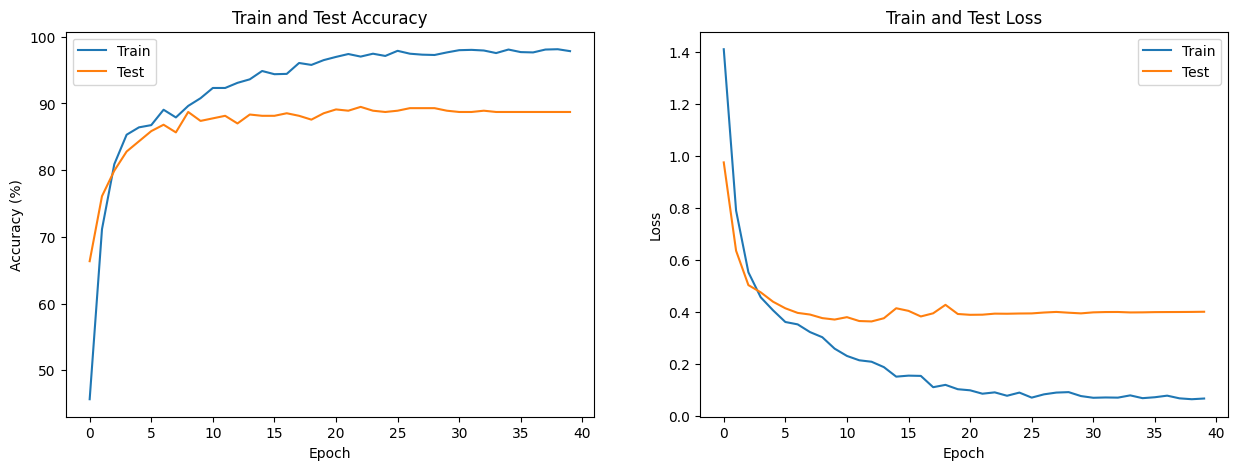

In [ ]:
import matplotlib.pyplot as plt

#Plotting train and test accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_accs, label="Train")
ax1.plot(test_accs, label="Test")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy (%)")
ax1.set_title("Train and Test Accuracy")
ax1.legend()

#Plotting train and test loss
ax2.plot(train_losses, label="Train")
ax2.plot(test_losses, label="Test")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_title("Train and Test Loss")
ax2.legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report

y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

target_names = ["Banana", "Forest", "Legumes", "Maize", "Other", "Structure"]
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      Banana       0.98      0.98      0.98        88
      Forest       0.93      0.97      0.95       130
     Legumes       0.66      0.61      0.63        38
       Maize       0.92      0.94      0.93       156
       Other       0.72      0.66      0.69        77
   Structure       0.91      0.94      0.93        34

    accuracy                           0.89       523
   macro avg       0.85      0.85      0.85       523
weighted avg       0.88      0.89      0.88       523



In [ ]:
from skimage import feature, io
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

#Extract HOG features from the images
X = []
y = []
for i, row in df.iterrows():
    #Load the image
    img = io.imread(row["Equalized Image"])
    #Extract HOG features
    hog_features = feature.hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=True, channel_axis=-1)
    #Append features and labels to X and y
    X.append(hog_features)
    y.append(row["Label Data"])


In [ ]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Train the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)
svm_report = classification_report(y_test, svm_pred, target_names=df["Label Data"].unique())

In [ ]:
#Print the results
print(f"SVM accuracy: {svm_acc:.2f}")
print(svm_report)

SVM accuracy: 0.52
              precision    recall  f1-score   support

      banana       0.65      0.58      0.61        85
       maize       0.46      0.69      0.55       123
     legumes       0.11      0.02      0.04        44
   structure       0.58      0.64      0.61       160
       other       0.33      0.24      0.28        78
      forest       0.74      0.44      0.55        32

    accuracy                           0.52       522
   macro avg       0.48      0.44      0.44       522
weighted avg       0.50      0.52      0.50       522



In [ ]:
#Train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
knn_acc = accuracy_score(y_test, knn_pred)
knn_report = classification_report(y_test, knn_pred, target_names=df["Label Data"].unique())


In [ ]:
print(f"KNN accuracy: {knn_acc:.2f}")
print(knn_report)

KNN accuracy: 0.20
              precision    recall  f1-score   support

      banana       0.00      0.00      0.00        85
       maize       0.25      0.53      0.34       123
     legumes       0.07      0.25      0.11        44
   structure       0.00      0.00      0.00       160
       other       0.20      0.27      0.23        78
      forest       0.83      0.31      0.45        32

    accuracy                           0.20       522
   macro avg       0.23      0.23      0.19       522
weighted avg       0.15      0.20      0.15       522

